In [1]:
import sympy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import dataset
import dataset_feynman1d
import dataset_feynman2d
import dataset_physics
import dataset_misc1d
import dataset_misc2d
import dataset_misc3d
from backprop import library, project, diversify
from gp import gp
from gp import creator as gp_creator
from gp import evaluator as gp_evaluator, selector as gp_selector
from gp import crossover as gp_crossover, mutator as gp_mutator
from gp import corrector as gp_corrector
from symbols import syntax_tree
import randstate

In [2]:
SAMPLE_SIZE = 200
TRAIN_SIZE  = 0.7
NOISE       = 0.#05
MESH_SIZE   = 100

POPSIZE          = 300
MAX_STREE_DEPTH  = 5
MAX_STREE_LENGTH = 20
GENERATIONS      = 50
GROUP_SIZE       = 5  # tournament selector.
MUTATION_RATE    = 0.15
ELITISM          = 1

LIBSIZE       = 2000
LIB_MAXDEPTH  = 3
LIB_MAXLENGTH = 10

RANDSTATE = None#124

In [3]:
randstate.setstate(RANDSTATE)

S = dataset_misc1d.MagmanDatasetScaled()
#S = dataset_misc2d.Resistance2()
#S = dataset_misc1d.ABSDataset()
#S = dataset_misc3d.Gravity()
#S = dataset_feynman2d.FeynmanICh6Eq20()
#S = dataset_feynman1d.FeynmanIICh27Eq16()
#S = dataset_physics.AircraftLift()

S.sample(size=SAMPLE_SIZE, noise=NOISE, mesh=False)
#S.load('../data/magman.csv')

S.split(train_size=TRAIN_SIZE)
#S.get_plotter().plot(width=8, height=6, plot_knowldege=False)

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)

In [4]:
np.seterr(all='ignore')

syntax_tree.SyntaxTreeInfo.set_problem(S_train)

y_iqr = S_train.get_y_iqr()
solutionCreator = gp_creator.PTC2RandomSolutionCreator(nvars=S.nvars, y_iqr=y_iqr)

multiMutator = gp_mutator.MultiMutator(
      gp_mutator.SubtreeReplacerMutator(MAX_STREE_DEPTH, MAX_STREE_LENGTH, solutionCreator),
      gp_mutator.FunctionSymbolMutator(),
      gp_mutator.NumericParameterMutator(all=True, y_iqr=y_iqr),
      #gp.NumericParameterMutator(all=False, y_iqr=y_iqr)
      )

X_mesh         = S_train.spsampler.meshspace(S_train.xl, S_train.xu, MESH_SIZE)
know_evaluator = gp_evaluator.KnowledgeEvaluator(S.knowledge, X_mesh)
r2_evaluator   = gp_evaluator.R2Evaluator(S_train)
evaluator      = gp_evaluator.LayeredEvaluator(know_evaluator, r2_evaluator)

selector  = gp_selector.TournamentSelector(GROUP_SIZE)
crossover = gp_crossover.SubTreeCrossover(MAX_STREE_DEPTH, MAX_STREE_LENGTH)
corrector = gp_corrector.Corrector(S_train, S.knowledge, MAX_STREE_DEPTH, MAX_STREE_LENGTH, X_mesh, LIBSIZE, LIB_MAXDEPTH, LIB_MAXLENGTH, solutionCreator)

symb_regressor = \
         gp.GP(POPSIZE, GENERATIONS, MAX_STREE_DEPTH, MAX_STREE_LENGTH, S_train, S_test,
               creator=solutionCreator,
               evaluator=evaluator,
               selector=selector,
               crossover=crossover,
               mutator=multiMutator,
               corrector=corrector,
               mutrate=MUTATION_RATE,
               elitism=ELITISM,
               knowledge=S.knowledge)

import profiling

with tqdm(total=symb_regressor.ngen-1) as pbar:
      def on_newgen(genidx, status):
            pbar.update(1)
            pbar.set_description(status)
      best_stree, best_eval = symb_regressor.evolve(newgen_callback=on_newgen)

profiling.print_stats()

print("\n--- Best syntax tree ---")
print(best_stree)
print(best_eval)
print(f"Max depth: {best_stree.get_max_depth()}")
print(f"Length: {best_stree.get_nnodes()}")
#if corrector is not None: print(f"Lib radius faults: {corrector.lib.get_radius_faults()}")

  0%|          | 0/49 [00:00<?, ?it/s]

         6590013 function calls (5756011 primitive calls) in 17.937 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    14700    0.319    0.000   17.920    0.001 corrector.py:24(correct)
    14437    0.142    0.000    9.192    0.001 library.py:496(cquery)
    11772    0.656    0.000    8.242    0.001 library.py:520(__local_cquery)
    14700    0.159    0.000    5.278    0.000 corrector.py:72(backprop_know)
   275658    1.179    0.000    4.995    0.000 constraints.py:45(match_key)
   249050    0.426    0.000    3.816    0.000 <__array_function__ internals>:177(array_equal)
   249050    2.124    0.000    3.337    0.000 numeric.py:2407(array_equal)
    14973    0.030    0.000    3.090    0.000 library.py:76(query)
    14973    2.086    0.000    3.059    0.000 _kdtree.py:363(query)
206249/27419    0.445    0.000    2.231    0.000 binop.py:28(__getitem__)
   536980    1.362    0.000    1.362    0.000 _methods.py:61(_all)
45320

In [5]:
profiling.print_stats()

         6590013 function calls (5756011 primitive calls) in 17.937 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    14700    0.319    0.000   17.920    0.001 corrector.py:24(correct)
    14437    0.142    0.000    9.192    0.001 library.py:496(cquery)
    11772    0.656    0.000    8.242    0.001 library.py:520(__local_cquery)
    14700    0.159    0.000    5.278    0.000 corrector.py:72(backprop_know)
   275658    1.179    0.000    4.995    0.000 constraints.py:45(match_key)
   249050    0.426    0.000    3.816    0.000 <__array_function__ internals>:177(array_equal)
   249050    2.124    0.000    3.337    0.000 numeric.py:2407(array_equal)
    14973    0.030    0.000    3.090    0.000 library.py:76(query)
    14973    2.086    0.000    3.059    0.000 _kdtree.py:363(query)
206249/27419    0.445    0.000    2.231    0.000 binop.py:28(__getitem__)
   536980    1.362    0.000    1.362    0.000 _methods.py:61(_all)
45320

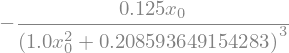

In [6]:
sympy.init_printing()
sympy.simplify(sympy.factor(best_stree.to_sympy()))

In [7]:
best_stree.clear_output()
#S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree, zoomout=1)
S.evaluate_extra(best_stree)

{'mse': 0.00019826580241080215,
 'rmse': 0.014080688989207956,
 'r2': 0.9995000211172107}

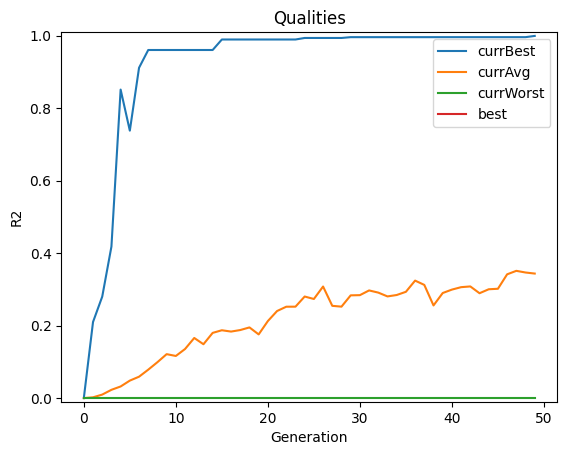

In [8]:
for quality, qseries in symb_regressor.stats.qualities.items():
    plt.plot(qseries, label=quality)

plt.legend()
plt.ylim((-0.01, 1.01))
plt.xlabel('Generation')
plt.ylabel('R2')
plt.title('Qualities')
plt.show()

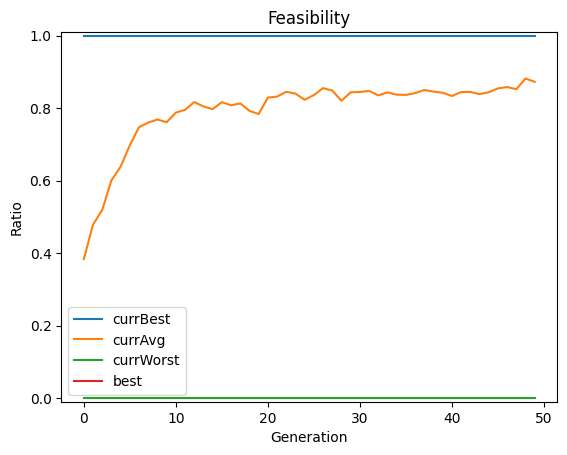

In [9]:
for quality, qseries in symb_regressor.stats.fea_ratio.items():
    plt.plot(qseries, label=quality)

plt.legend()
plt.ylim((-0.01, 1.01))
plt.xlabel('Generation')
plt.ylabel('Ratio')
plt.title('Feasibility')
plt.show()

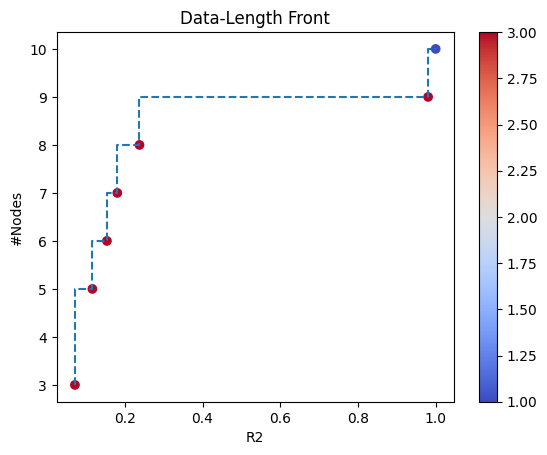

,Score,Model,Front,fpn,R2,Length,Symbset,Symbdist,Crowdist
0,0,(-0.01 / x0),0,0.061140,0.071929,3,(/),3,inf
1,1,(x0 / cube(((-0.42 - square(x0)) - square(x0)))),0,0.499757,0.999513,10,"(/, +, cube, square)",1,inf
2,2,((x0 * -0.05) / square((x0 - 0.01))),0,0.142757,0.237928,8,"(/, square)",3,1.147257
3,3,((x0 * -0.19) / square((0.10 + square(x0)))),0,0.539061,0.980110,9,"(/, square)",3,1.106756
4,4,(0.02 / (0.01 - x0)),0,0.087618,0.116823,5,(/),3,0.517246
5,5,(0.91 / (0.32 - (x0 / 0.03))),0,0.117622,0.180957,7,(/),3,0.375998
6,6,((x0 * -0.05) / square(x0)),0,0.107927,0.154182,6,"(/, square)",3,0.354855
7,0,(-0.00 / x0),1,0.013189,0.015516,3,(/),3,inf
8,1,((x0 / ((square(x0) + square(x0)) - -0.13)) / ...,1,0.000000,0.996108,20,"(/, +, cube, square)",2,inf
9,2,((x0 * -0.23) / square((0.16 + square(x0)))),1,0.504676,0.917593,9,"(/, square)",2,1.102123


In [10]:
pd_data = []
front_tracker = symb_regressor.fea_front_tracker.front_tracker_a

for frontidx in range(front_tracker.nfronts):

    front = front_tracker.get_front(frontidx)
    symbset, symbdist = front_tracker.compute_symbdist(frontidx)
    crowdist = front_tracker.compute_crowdist(frontidx)
    
    for idx, (stree, data, length) in enumerate(front):
        pd_data.append(
            [idx, stree, frontidx, data*(1.-min(1.,length/20)), data, length, symbset[id(stree)], symbdist[id(stree)], crowdist[id(stree)]]
        )

front_tracker.plot(0)
pd.DataFrame(pd_data, columns=['Score', 'Model', 'Front', 'fpn', 'R2', 'Length', 'Symbset', 'Symbdist', 'Crowdist']).head(n=60)
#print(front_tracker.symbfreq.freq)
#print(symb_regressor.fea_front_tracker.front_tracker_b.symbfreq.freq)